## Dimensionality reduction as a means of denoising
In the first problem set, you were exposed to image denoising with an SVD approximation (linear PCA). In this problem we intend to generalize those results. <br>
__Your tasks:__ <br>
__1:__ Download the MNIST dataset. <br>
__2:__ Train a fully-connected denoising autoencoder with PyTorch. Your inputs to the network must be noisy versions of the original batches. You should use a zero-mean gaussian noise that has a variance of at least 0.5, when images are normalized to $[0,1]$. <br>
__3:__ Select a random image from each class, and display its original, noisy and denoised versions. <br>
__4:__ Do the same for PCA and kernel PCA denoising with different kernels (polynomial and rbf) and repeat part 3 in each case. The number of components should be equal to the number of features in the middle layer of the autoencoder. In this part, you can use a subset of the dataset. What happens (in practice) if you do not select a subset for a kernel PCA?

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from sklearn.decomposition import KernelPCA, PCA

<font color="yellowgreen"> <h1> Step 1 </h1> </font>

Downloading the MNIST dataset and create the train and test sets

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = MNIST(root='./data', train=True, download=True, transform=transform)
testset = MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:01<00:00, 5139593.83it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 225513.06it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1850418.10it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



<font color="yellowgreen"> <h1> Step 2 </h1> </font>

Defining and training the autoencoder <br>

Our fully connected autoencoder contains the followings:
- __Encoder__:<br>
In our fully connected autoencoder, the encoder section consists of three linear layers. The first linear layer takes the flattened input image of size 28x28 (784 dimensions) and maps it to a hidden layer of size 128. The ReLU activation function is applied after each linear layer. The second linear layer reduces the dimensionality further to 64, and the third linear layer further reduces it to 32, which serves as the encoded representation.

- __Decoder__: <br>
The decoder also consits of three layers. The first linear layer takes the encoded representation of size 32 and maps it back to a hidden layer of size 64. Again, ReLU activation is applied after each linear layer. The second linear layer increases the dimensionality to 128, and the final linear layer maps it back to the original image size of 28x28 (784 dimensions). The Sigmoid activation function is applied after this final linear layer to ensure the output pixel values are within the range of [0, 1]

### Training
The code starts by setting up the data loader to load the training images in mini-batches. It then initializes the autoencoder model and defines the loss function and optimizer. The training loop begins, where for each epoch, the code iterates over the mini-batches of the training data. Inside the loop, it adds Gaussian noise to the input images, reconstructs them using the autoencoder, calculates the reconstruction loss, and updates the model's parameters using backpropagation. After each epoch, the loss is printed.


In [7]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Set random seed for reproducibility
torch.manual_seed(0)

# Define the dataloader
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)

# Define the loss function and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for data in trainloader:
        images, _ = data
        images = images.to(device)
        noisy_images = images + torch.randn_like(images) * 0.5  # Add Gaussian noise
        noisy_images = torch.clamp(noisy_images, 0, 1)  # Clip values to [0, 1]
        noisy_images = noisy_images.view(-1, 28 * 28)
        noisy_images = noisy_images.to(device)
        
        # Forward pass
        outputs = autoencoder(noisy_images)
        loss = criterion(outputs, noisy_images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Device: cuda
Epoch [1/10], Loss: 0.5503
Epoch [2/10], Loss: 0.5371
Epoch [3/10], Loss: 0.5310
Epoch [4/10], Loss: 0.5270
Epoch [5/10], Loss: 0.5269
Epoch [6/10], Loss: 0.5228
Epoch [7/10], Loss: 0.5215
Epoch [8/10], Loss: 0.5197
Epoch [9/10], Loss: 0.5209
Epoch [10/10], Loss: 0.5207


<font color="yellowgreen"> <h1> Step 3 </h1> </font>
Display original, noisy, and denoised images from each class <br>

We start by selecting one random image per class from the training dataset. These selected images are then normalized and noisy versions are created by adding random Gaussian noise. The images are reshaped to match the expected input size of the autoencoder. Next, the images and noisy images are moved to the specified device (CPU or GPU). The autoencoder is then applied to the noisy images to obtain denoised versions. The denoised, original, and noisy images are visualized using matplotlib, with each row representing a different class. The original image, noisy image, and denoised image are displayed side by side for each class. Finally, the plot is shown with the three types of images.

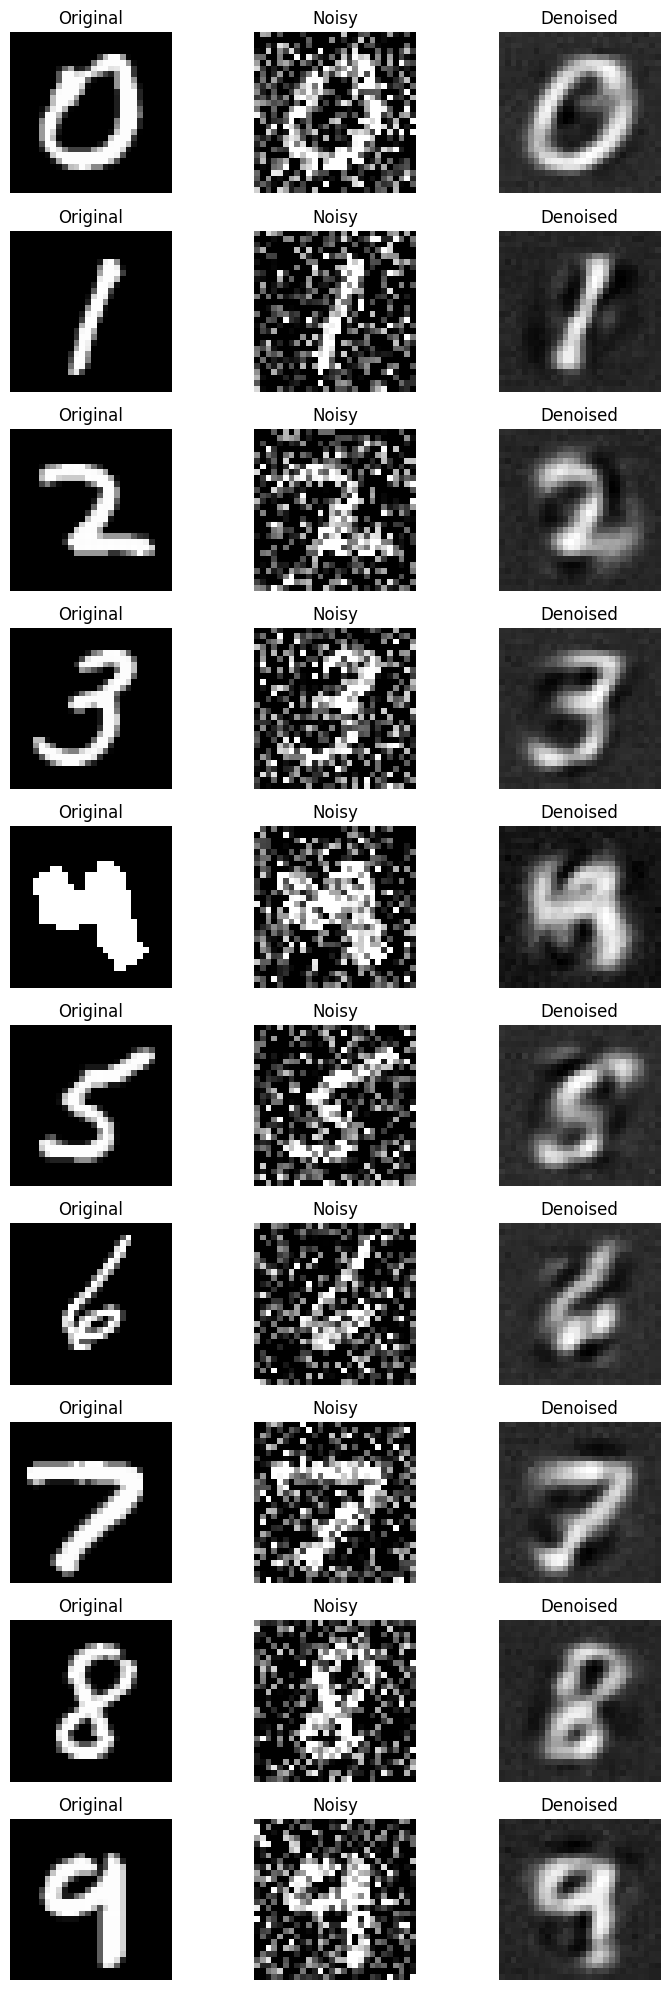

In [13]:
class_labels = range(10)
num_samples_per_class = 1

# Select random images from each class
selected_images = []
for label in class_labels:
    class_indices = np.where(np.array(trainset.targets) == label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    selected_images.extend(trainset.data[selected_indices])

selected_images = torch.stack(selected_images) / 255.0  # Normalize to [0, 1]
selected_noisy_images = selected_images + torch.randn_like(selected_images) * 0.5
selected_noisy_images = torch.clamp(selected_noisy_images, 0, 1)
selected_images = selected_images.view(-1, 28 * 28)
selected_noisy_images = selected_noisy_images.view(-1, 28 * 28)
selected_images = selected_images.to(device)
selected_noisy_images = selected_noisy_images.to(device)

# Get denoised images from the autoencoder
denoised_images = autoencoder(selected_noisy_images)

denoised_images = denoised_images.cpu().view(-1, 28, 28)
selected_images = selected_images.cpu().view(-1, 28, 28)
selected_noisy_images = selected_noisy_images.cpu().view(-1, 28, 28)

# Display original, noisy, and denoised images
fig, axs = plt.subplots(len(class_labels), 3, figsize=(8, 2 * len(class_labels)), tight_layout=True)
for i, label in enumerate(class_labels):
    # Original image
    axs[i, 0].imshow(selected_images[i].view(28, 28), cmap='gray')
    axs[i, 0].set_title("Original")

    # Noisy image
    axs[i, 1].imshow(selected_noisy_images[i].view(28, 28), cmap='gray')
    axs[i, 1].set_title("Noisy")

    # Denoised image
    axs[i, 2].imshow(denoised_images[i].detach().numpy(), cmap='gray')
    axs[i, 2].set_title("Denoised")

    for ax in axs[i]:
        ax.axis("off")

plt.show()

<font color="yellowgreen"> <h1> Step 4: Perform PCA and Kernel PCA denoising </h1> </font>

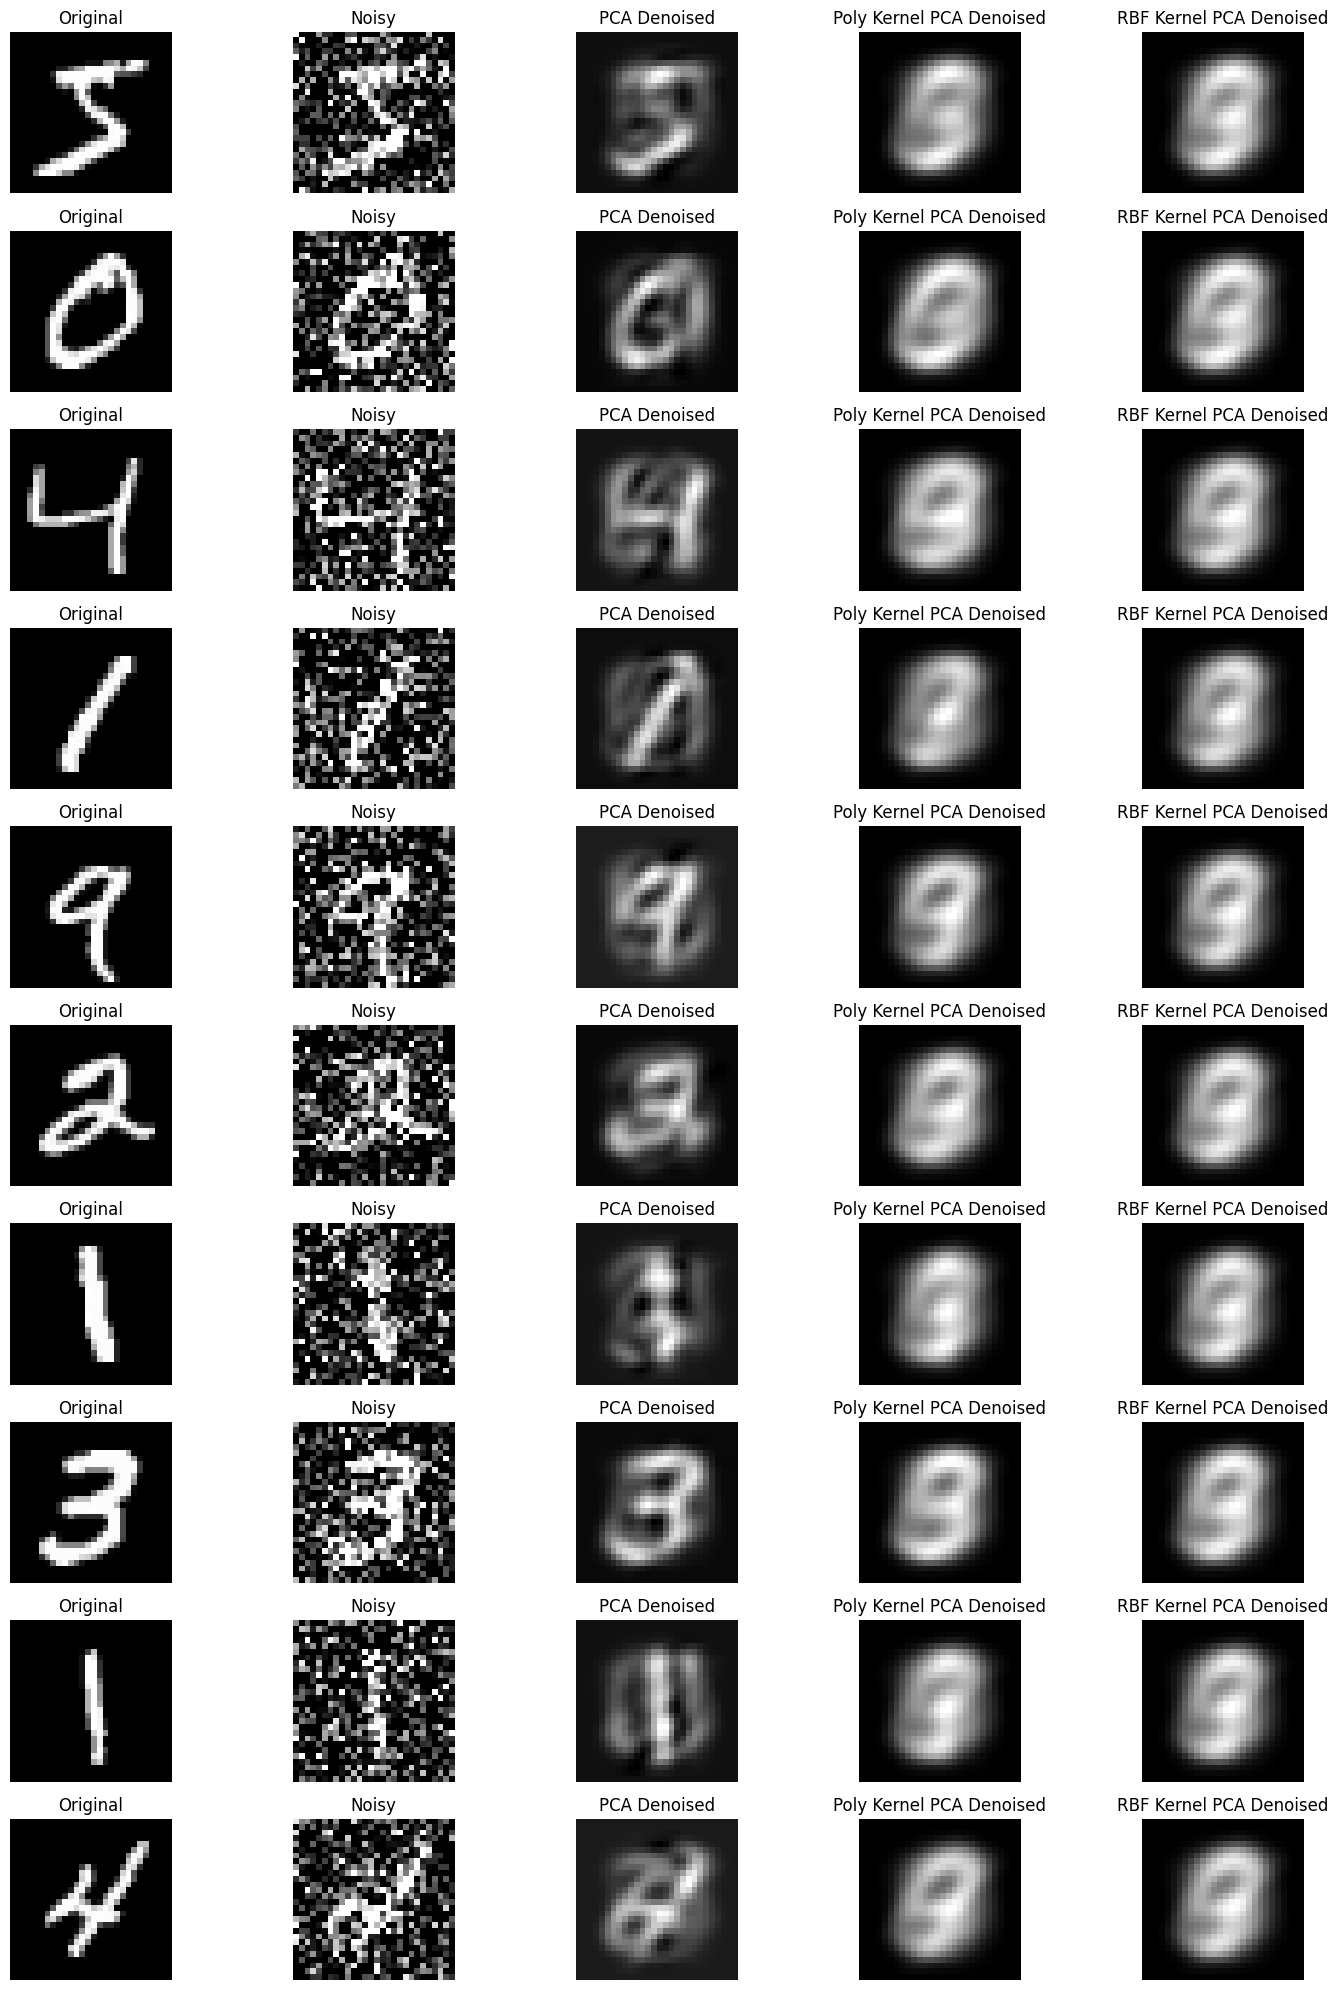

In [62]:
# Subset of the dataset for kernel PCA
subset_size = 5000
subset_images = trainset.data[:subset_size].view(-1, 28 * 28) / 255.0

# Construct noisy images using the subset
selected_noisy_images = subset_images + torch.randn_like(subset_images) * 0.5
selected_noisy_images = torch.clamp(selected_noisy_images, 0, 1)
selected_noisy_images = selected_noisy_images.view(-1, 28 * 28)

# PCA denoising
pca = PCA(n_components=32)  # Use the same number of components as the autoencoder's middle layer
pca.fit(subset_images)
pca_denoised_images = pca.inverse_transform(pca.transform(selected_noisy_images))

# Kernel PCA denoising with polynomial kernel
poly_kernel_pca = KernelPCA(n_components=32, kernel='poly', fit_inverse_transform=True)
poly_kernel_pca.fit(subset_images)
poly_kernel_pca_denoised_images = poly_kernel_pca.inverse_transform(poly_kernel_pca.transform(selected_noisy_images))

# Kernel PCA denoising with RBF kernel
rbf_kernel_pca = KernelPCA(n_components=32, kernel='rbf', fit_inverse_transform=True)
rbf_kernel_pca.fit(subset_images)
rbf_kernel_pca_denoised_images = rbf_kernel_pca.inverse_transform(rbf_kernel_pca.transform(selected_noisy_images))

# Display original, noisy, and denoised images from PCA and Kernel PCA
fig, axs = plt.subplots(len(class_labels), 5, figsize=(15, 2 * len(class_labels)), tight_layout=True)
for i, label in enumerate(class_labels):
    # Original image
    axs[i, 0].imshow(subset_images[i].view(28, 28), cmap='gray')
    axs[i, 0].set_title("Original")

    # Noisy image
    axs[i, 1].imshow(selected_noisy_images[i].view(28, 28), cmap='gray')
    axs[i, 1].set_title("Noisy")

    # PCA denoised image
    axs[i, 2].imshow(pca_denoised_images[i].reshape(28, 28), cmap='gray')
    axs[i, 2].set_title("PCA Denoised")

    # Kernel PCA denoised image with polynomial kernel
    axs[i, 3].imshow(poly_kernel_pca_denoised_images[i].reshape(28, 28), cmap='gray')
    axs[i, 3].set_title("Poly Kernel PCA Denoised")

    # Kernel PCA denoised image with RBF kernel
    axs[i, 4].imshow(rbf_kernel_pca_denoised_images[i].reshape(28, 28), cmap='gray')
    axs[i, 4].set_title("RBF Kernel PCA Denoised")

    for ax in axs[i]:
        ax.axis("off")

plt.show()

When applying kernel PCA without selecting a subset of the dataset, several practical implications arise. Firstly, the computational complexity increases as the kernel matrix, which has a size proportional to the square of the number of data points, needs to be calculated. This can lead to significant computational expenses and memory requirements, potentially causing memory errors. Additionally, interpreting the results becomes more challenging, especially for high-dimensional datasets, as the transformed features may lack interpretability. Moreover, using the entire dataset for kernel PCA increases the risk of overfitting, as the model has access to all data points. Selecting a subset for kernel PCA helps mitigate these challenges, making computations more efficient, reducing memory requirements, facilitating interpretability, and reducing the risk of overfitting.

## Bonus: Spectral clustering in graphs, and feature selection

In this question, you will create stochastic block model graphs, and the use kmeans as a clustering method on it. <br>
In a block stochastic model, there are k clusters, and each node is connected to other nodes from the same cluster with probability p, and is connected to other nodes with probability $q<p$. Recall that for an undirected graph without loops, we can define the adjacency matrix as:
$$A_{ij}=\begin{cases}
1 & \text{if }i\neq j \text{ and i and j are connected} \\
0 & \text{otherwise}
\end{cases}$$
Note that $A^T=A$, and the degree of each node can be calculated as: $d=A1$. Now we define the laplacian and normalized laplacian as follows: 
$$D=diag(d)\quad L=D-A \quad L_N=I-D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$$
__Spectral clusteing:__ We can use the k eigenvectors with the lowest eigenvalues of the laplacian or the normalized laplacian for clustering. Both matrices are positive semidefinite and have a zero eigenvalue (DC vector for $L$). <br>
__Note:__ Hermitian matrices are always diagonalizable, so do not worry about eigenvalue multiplicity at all. <br>
### Your task:
__1:__ Define a function the given the number of nodes n, the number of clusters k, p and q, returns the adjacency matrix of a block stochastic graph. To this end, you should generate a random clustering, and then create the adjacency matrix. Also return your clustering. You are not allowed to loop over n and must use vectorized operations. <br>
__2:__ Define a function that based on the number of clusters k and the adjacency matrix, returns the mentioned eigenvectors of $L$ and $L_N$.<br>
__3:__ Visualize the data on scatterplots for n=1000, p=0.6, q=0.3 and for k=2 and k=3 (For k=3, use the second and third eigenvector for visualization as the first one is the DC vector).<br>
__4:__ Perform kmeans on the features using sklearn, and report the accuracies. Your evaluation must be invariant to index permutations.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import default_rng

In [76]:
def generate_block_stochastic_graph(n, k, p, q):
    # Generate random clustering
    clustering = np.random.randint(k, size=n)
    
    # Create adjacency matrix
    adjacency_matrix = np.zeros((n, n))
    for i in range(k):
        indices = np.where(clustering == i)[0]
        adjacency_matrix[np.ix_(indices, indices)] = np.random.choice([0, 1], size=(len(indices), len(indices)), p=[1-q, q])
    
    return adjacency_matrix, clustering

def get_eigenvectors(adjacency_matrix, k):
    # Calculate Laplacian matrix
    degree = np.sum(adjacency_matrix, axis=1)
    laplacian = np.diag(degree) - adjacency_matrix
    
    # Calculate normalized Laplacian matrix
    sqrt_degree = np.sqrt(degree)
    normalized_laplacian = np.eye(adjacency_matrix.shape[0]) - (adjacency_matrix / np.outer(sqrt_degree, sqrt_degree))
    
    # Calculate eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(laplacian)
    sorted_indices = np.argsort(eigenvalues)[:k]
    laplacian_eigenvectors = eigenvectors[:, sorted_indices]
    
    eigenvalues, eigenvectors = np.linalg.eig(normalized_laplacian)
    sorted_indices = np.argsort(eigenvalues)[1:k+1]  # Exclude the first eigenvector (DC vector)
    normalized_laplacian_eigenvectors = eigenvectors[:, sorted_indices]
    
    return laplacian_eigenvectors, normalized_laplacian_eigenvectors

def visualize_scatterplot(data, clustering, k):
    fig, ax = plt.subplots()
    for i in range(k):
        indices = np.where(clustering == i)[0]
        ax.scatter(data[indices, 0], data[indices, 1], label=f'Cluster {i+1}')
    ax.legend()
    plt.show()

def calculate_accuracy(true_labels, predicted_labels):
    # Calculate accuracy considering index permutations
    matching = sum(true_labels[i] == predicted_labels[i] for i in range(len(true_labels)))
    return matching / len(true_labels)


<font color="yellowgreen"> <h3> Explanation </h3> </font>

Here's a brief explanation of each function:

- __generate_block_stochastic_graph:__ This function generates a block stochastic graph with a specified number of nodes (n) and clusters (k). It randomly assigns each node to a cluster and creates an adjacency matrix for the graph. The adjacency matrix determines the connections between nodes based on the assigned clusters, using a probability q for intra-cluster connections and (1 - q) for inter-cluster connections. It returns the adjacency matrix and the cluster assignments.

- __get_eigenvectors:__ This function takes an adjacency matrix and the number of desired eigenvectors (k) as input. It calculates the Laplacian matrix of the graph and the normalized Laplacian matrix. Then, it computes the eigenvectors corresponding to the smallest eigenvalues of both matrices. The function returns the eigenvectors associated with the Laplacian matrix and the eigenvectors associated with the normalized Laplacian matrix.

- __visualize_scatterplot:__ This function visualizes a scatter plot of the given data points (data) based on the provided clustering assignments (clustering). It plots the data points with different colors based on their assigned clusters (k).

- __calculate_accuracy:__ This function calculates the accuracy of the clustering results. It takes the true cluster labels (true_labels) and the predicted cluster labels (predicted_labels) as input. It compares the labels at each index and calculates the percentage of matching labels. The function returns the accuracy score.

c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


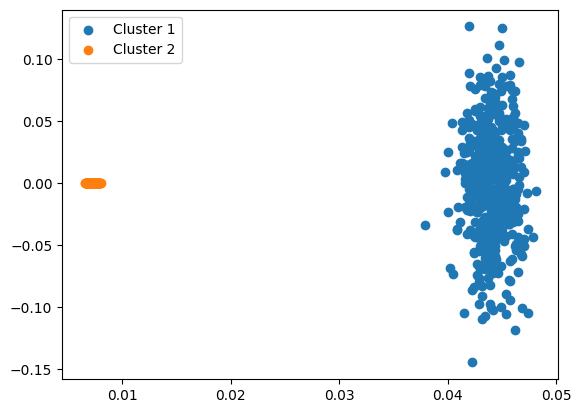

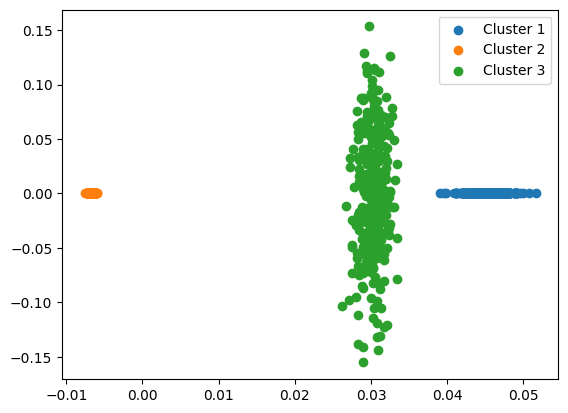

Accuracy: 0.784


c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [77]:
# Parameters
n = 1000
p = 0.6
q = 0.3

# Task 1: Generate block stochastic graph
k = 2
adjacency_matrix, clustering = generate_block_stochastic_graph(n, k, p, q)

# Task 2: Get eigenvectors of L and L_N
k_eigenvectors_laplacian, k_eigenvectors_normalized_laplacian = get_eigenvectors(adjacency_matrix, k)

# Task 3: Visualize scatterplots
visualize_scatterplot(k_eigenvectors_normalized_laplacian, clustering, k)

k = 3
adjacency_matrix, clustering = generate_block_stochastic_graph(n, k, p, q)
k_eigenvectors_laplacian, k_eigenvectors_normalized_laplacian = get_eigenvectors(adjacency_matrix, k)

visualize_scatterplot(k_eigenvectors_normalized_laplacian[:, 1:], clustering, k)

# Task 4: Perform k-means and calculate accuracies
kmeans = KMeans(n_clusters=k)
kmeans.fit(np.real(k_eigenvectors_normalized_laplacian[:, 1:]))  # Take the real part of the eigenvectors
predicted_labels = kmeans.labels_

accuracy = calculate_accuracy(clustering, predicted_labels)
print(f"Accuracy: {accuracy}")
